### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- Modeling (this notebook)
- [Model Tuning](./04_tuning.ipynb)
- [Experiments](./04a_experiments.ipynb)
- [Results and Recommendations](./05_results.ipynb)

**In this notebook, you'll find:**
- Classification models for each of the 3 datasets
- TODO etc.

In [80]:
# The usual imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time # for timing model fits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# imbalanced class handling
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.pipeline import Pipeline as ImbalancedPipeline

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# principal component analysis
from sklearn.decomposition import PCA

# neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.metrics import recall_score, f1_score, precision_score

# to persist our models for later use
import pickle

##### Universal model evaluation function
- We will use the below Dataframe and functions to accumulate metrics on all of our models across all of our datasets to facilitate
evaluation and production model selection.
- We've chosen to make 2 different versions of our **model_trials** function - the first is for non-neural-network models, and the second
is for neural networks - to accommodate the differences in parameters, fitting, and scoring between the 2 types of models.
- Thanks to Cynthia Rodriguez for this one!

In [81]:
# Dataframe to collect results
model_trials_df = pd.DataFrame(columns=['dataset_name', 'model_used', 'model_params', 'train_score', 'test_score',
'accuracy', 'specificity', 'precision', 'recall', 'f1 score', 'true_neg', 'false_pos', 'false_neg', 'true_pos'])

def model_trials(dataset_name, X, y, model, model_id, scale_first = False, gs_params = None):
    '''
    Takes in dataset information and a (non-neural-net) model, fits the model, and appends fit metrics to a previously
    established Dataframe for later comparison. Also displays confusion matrix upon completion.

    Parameters:
    - dataset_name (string): used to differentiate between the NY/FL/GA models
    - X (Dataframe): features dataframe for all observations
    - y (Dataframe or Series): target classes for all observations:
    - model (classification model): non-neural-net model to fit
    - model_id (string): friendly name for model to include in results
    - scale_first (boolean): indicates whether the feature set X should be scaled before fitting
    - gs_params (dict): parameters for a GridSearch - if None, model will be fit without GridSearching

    Returns:
    - ConfusionMatrixDisplay graphic for fitted model
    - Also appends results to previously established metrics dataframe
    '''

    '''Setting X and y, and fitting the model'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    '''Scale if needed'''
    if (scale_first):
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

    if (gs_params):
        gs = GridSearchCV(model, gs_params)
        gs.fit(X_train, y_train)
        model = gs.best_estimator_
        model_params = gs.best_params_
    else:
        model.fit(X_train, y_train)
        model_params = model.get_params()

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Calculating classification rates'''
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_trials dataframe'''
    model_list = [dataset_name, model_id, model_params, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show scores and classification metrics'''
    print(f'Dataset: {dataset_name}')
    print(f'Model ID: {model_id}')
    print(f'Model Params: {model_params}')
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')

    '''Returning a confusion matrix colored based on performance against the baseline'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='viridis', values_format='d');
    else: 
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='magma', values_format='d');

In [82]:
# neural net version
def model_trials_nn(dataset_name, X, y, model, model_id, epochs = 10, batch_size = 32):
    '''
    Takes in dataset information and a neural network model, fits the model, and appends fit metrics to a previously
    established Dataframe for later comparison. Also displays confusion matrix upon completion. NOTE: assumes model's
    output layer uses the sigmoid activation function (i.e., binary classification) and was compiled with 'accuracy' among its metrics.

    Parameters:
    - dataset_name (string): used to differentiate between the NY/FL/GA models
    - X (Dataframe): features dataframe for all observations
    - y (Dataframe or Series): target classes for all observations:
    - model (classification model): neural network model to fit
    - model_id (string): friendly name for model to include in results
    - epochs (int): number of neural network epochs to run
    - batch_size (int): size of neural network batch

    Returns:
    - ConfusionMatrixDisplay graphic for fitted model
    - Also appends results to previously established metrics dataframe
    '''

    '''Setting X and y, and fitting the model'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    '''Always scale for neural nets!'''
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    res = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size, verbose = 0)
    model_params = {'epochs': epochs, 'batch_size': batch_size} # all we'll capture for these - there are too many weights to be useful!
        
    train_score = res.history['accuracy'][-1]
    test_score = res.history['val_accuracy'][-1]

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Calculating classification rates'''
    '''Assumes a 0.5 probability threshold'''
    preds = [1 if x >= 0.5 else 0 for x in model.predict(X_test)[:, 0]]
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_trials dataframe'''
    model_list = [dataset_name, model_id, model_params, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show scores and classification metrics'''
    print(f'Dataset: {dataset_name}')
    print(f'Model ID: {model_id}')
    print(f'Model Params: {model_params}')
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')

    '''Returning a confusion matrix colored based on performance against the baseline'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'viridis', values_format = 'd');
    else: 
        return ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'magma', values_format = 'd');

---
**Model 1: Base feature set - New York**

In [83]:
# read in the clean NY data and remind ourselves what it looks like
ny_df = pd.read_csv('../data/NY/NY_final.csv')
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
0,2008,UNKNOWN,MALE,55,Not Returned,0,1
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
2,2008,ALBANY,MALE,17,Not Returned,0,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
4,2008,ALBANY,MALE,18,Not Returned,0,1


##### Basic Models- Two Features Gender and Age

In [84]:
# Define X and y
X = ny_df[['gender_map', 'Age at Release']]
y = ny_df['recidivism']

Dataset: NY
Model ID: LogisticRegression w/gender + age
Model Params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Score: 0.5868
Testing Score: 0.5879 

Accuracy: 0.5879
Specificity: 0.9707
Precision: 0.5615
Recall: 0.0525
F1 Score: 0.096 

Best accuracy rate confusion matrix:


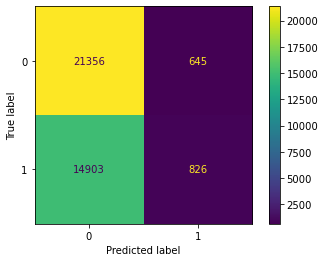

In [85]:
# Vanilla Logistic Regression
ny_logreg = LogisticRegression()
model_trials('NY', X, y, ny_logreg, 'LogisticRegression w/gender + age');

Dataset: NY
Model ID: RandomForest w/gender + age
Model Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Training Score: 0.5883
Testing Score: 0.587 

Accuracy: 0.587
Specificity: 0.918
Precision: 0.5196
Recall: 0.124
F1 Score: 0.2002 

Best accuracy rate confusion matrix:


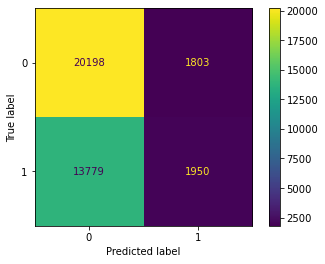

In [86]:
# Random Forest
ny_rf = RandomForestClassifier(random_state = 42)
model_trials('NY', X, y, ny_rf, 'RandomForest w/gender + age');

Dataset: NY
Model ID: AdaBoost w/gender + age
Model Params: {'algorithm': 'SAMME.R', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': None, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': 42, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(random_state=42), 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
Training Score: 0.5883
Testing Score: 0.587 

Accuracy: 0.587
Specificity: 0.918
Precision: 0.5196
Recall: 0.124
F1 Score: 0.2002 

Best accuracy rate confusion matrix:


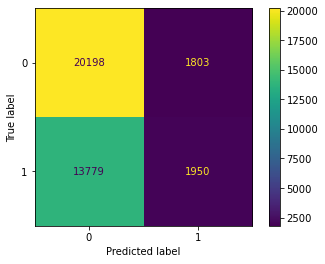

In [87]:
# AdaBoost
ny_ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42))
model_trials('NY', X, y, ny_ada, 'AdaBoost w/gender + age');

Dataset: NY
Model ID: GradientBoost w/gender + age
Model Params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Training Score: 0.5883
Testing Score: 0.587 

Accuracy: 0.587
Specificity: 0.9182
Precision: 0.5195
Recall: 0.1237
F1 Score: 0.1998 

Best accuracy rate confusion matrix:


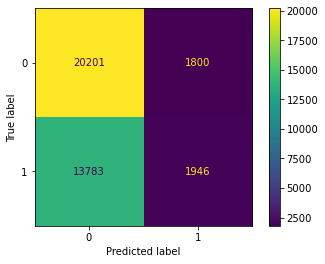

In [88]:
# GradientBoost
ny_gboost = GradientBoostingClassifier(random_state = 42)
model_trials('NY', X, y, ny_gboost, 'GradientBoost w/gender + age');

Dataset: NY
Model ID: Stack of RandomForest, GradientBoost, AdaBoost w/gender + age
Model Params: {'cv': None, 'estimators': [('random_forest', RandomForestClassifier()), ('gboost', GradientBoostingClassifier()), ('ada', AdaBoostClassifier())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'random_forest': RandomForestClassifier(), 'gboost': GradientBoostingClassifier(), 'ada': AdaBoostClassifie

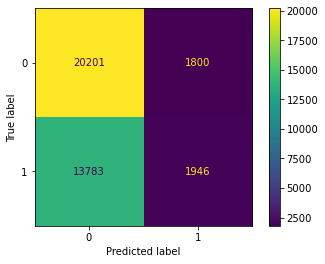

In [89]:
# Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier())
]

ny_stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

model_trials('NY', X, y, ny_stacked_model, 'Stack of RandomForest, GradientBoost, AdaBoost w/gender + age');

Dataset: NY
Model ID: KNeighbors w/gender + age
Model Params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Training Score: 0.5319
Testing Score: 0.5313 

Accuracy: 0.5313
Specificity: 0.6467
Precision: 0.428
Recall: 0.3698
F1 Score: 0.3968 

Best accuracy rate confusion matrix:


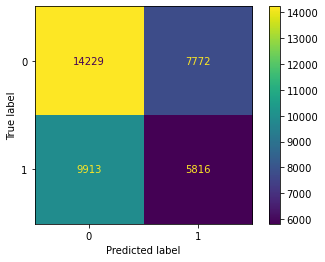

In [90]:
# KNN
ny_knn = KNeighborsClassifier()

model_trials('NY', X, y, ny_knn, 'KNeighbors w/gender + age', scale_first = True);

##### Models Including County, Gender, Age

In [91]:
# Creating a Dataframe including dummies of the county of indictment
df_dummies = pd.get_dummies(ny_df['County of Indictment'])
df_dummies['gender'] = ny_df['gender_map']
df_dummies['recidivism'] = ny_df['recidivism']
df_dummies['age'] = ny_df['Age at Release']

# Define X and y with dummy data
X = df_dummies.drop(columns = ['recidivism'])
y = df_dummies['recidivism']

c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Dataset: NY
Model ID: LogisticRegression w/county, gender + age
Model Params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Score: 0.5987
Testing Score: 0.599 

Accuracy: 0.599
Specificity: 0.8768
Precision: 0.5498
Recall: 0.2105
F1 Score: 0.3044 

Best accuracy rate confusion matrix:


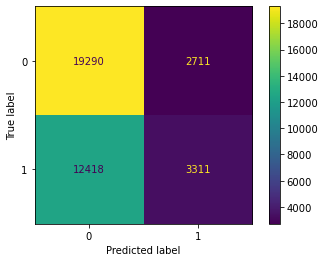

In [92]:
# Logistic Regression
ny_lr2 = LogisticRegression()
model_trials('NY', X, y, ny_lr2, 'LogisticRegression w/county, gender + age');

Dataset: NY
Model ID: RandomForest w/GridSearch w/county, gender + age
Model Params: {'max_depth': 15, 'max_features': 15, 'n_estimators': 120}
Training Score: 0.6029
Testing Score: 0.5976 

Accuracy: 0.5976
Specificity: 0.8931
Precision: 0.5522
Recall: 0.1844
F1 Score: 0.2764 

Best accuracy rate confusion matrix:


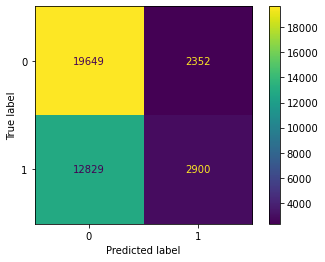

In [93]:
# Random Forest with Hyperparameter tuning
ny_rf2 = RandomForestClassifier(random_state = 42)
rf_params = {
    'n_estimators': [120, 130],
    'max_depth': [15, 20],
    'max_features' : [15, 20]
}

model_trials('NY', X, y, ny_rf2, 'RandomForest w/GridSearch w/county, gender + age', gs_params = rf_params);

Dataset: NY
Model ID: AdaBoost w/GridSearch w/county, gender + age
Model Params: {'base_estimator__max_depth': 1, 'n_estimators': 100}
Training Score: 0.5996
Testing Score: 0.6 

Accuracy: 0.6
Specificity: 0.8708
Precision: 0.5504
Recall: 0.2213
F1 Score: 0.3157 

Best accuracy rate confusion matrix:


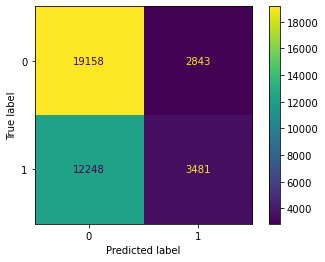

In [94]:
#Ada Boost with Hyperparameter tuning
ny_ada2 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42))

ada_params= {
    'n_estimators': [50, 100],
    'base_estimator__max_depth':[1, 3]
}

model_trials('NY', X, y, ny_ada2, 'AdaBoost w/GridSearch w/county, gender + age', gs_params = ada_params);

Dataset: NY
Model ID: GradientBoost w/county, gender + age
Model Params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Training Score: 0.5989
Testing Score: 0.5988 

Accuracy: 0.5988
Specificity: 0.9183
Precision: 0.5708
Recall: 0.152
F1 Score: 0.2401 

Best accuracy rate confusion matrix:


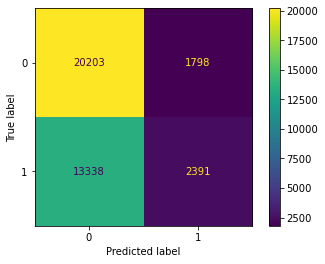

In [95]:
# Gradient Boost
ny_gboost2 = GradientBoostingClassifier(random_state = 42)
model_trials('NY', X, y, ny_gboost2, 'GradientBoost w/county, gender + age');

Dataset: NY
Model ID: Stack w/RandomForest + GradientBoost w/county, gender + age
Model Params: {'cv': None, 'estimators': [('random_forest', RandomForestClassifier()), ('gboost', GradientBoostingClassifier())], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 100, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l2', 'final_estimator__random_state': None, 'final_estimator__solver': 'lbfgs', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'random_forest': RandomForestClassifier(), 'gboost': GradientBoostingClassifier(), 'random_forest__bootstrap': True, 'random_forest__ccp_alp

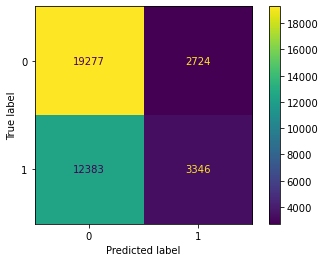

In [96]:
# Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier())
]

ny_stacked_model2 = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

model_trials('NY', X, y, ny_stacked_model2, 'Stack w/RandomForest + GradientBoost w/county, gender + age');

In [97]:
# Since we're about to create a neural network - remind ourselves of the number of inputs
X.shape

(188650, 65)

1180/1180 [==============================] - 1s 1ms/step
Dataset: NY
Model ID: FNN w/county, gender + age
Model Params: {'epochs': 10, 'batch_size': 32}
Training Score: 0.5997
Testing Score: 0.6005 

Accuracy: 0.6005
Specificity: 0.896
Precision: 0.5626
Recall: 0.1872
F1 Score: 0.2809 

Best accuracy rate confusion matrix:


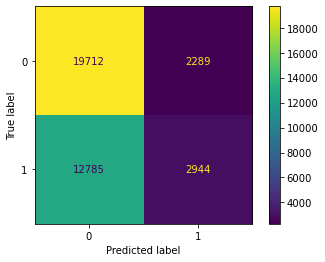

In [98]:
# Instantiate a CNN.
ny_nn = Sequential()

ny_nn.add(Dense(84, input_shape = (65,), activation = 'relu'))
ny_nn.add(Dense(64, activation = 'relu'))
ny_nn.add(Dense(32, activation = 'relu'))
ny_nn.add(Dense(1, activation = 'sigmoid'))

# Compile it
ny_nn.compile(loss = 'bce', optimizer = 'adam', metrics = ['accuracy'])

# Fit it
model_trials_nn('NY', X, y, ny_nn, 'FNN w/county, gender + age');

In [99]:
model_trials_df[model_trials_df['dataset_name'] == 'NY']

,dataset_name,model_used,model_params,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
0,NY,LogisticRegression w/gender + age,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.586841,0.587914,0.587914,0.970683,0.561523,0.052514,0.096047,21356,645,14903,826
1,NY,RandomForest w/gender + age,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.588332,0.587013,0.587013,0.918049,0.519584,0.123975,0.200185,20198,1803,13779,1950
2,NY,AdaBoost w/gender + age,"{'algorithm': 'SAMME.R', 'base_estimator__ccp_...",0.588332,0.587013,0.587013,0.918049,0.519584,0.123975,0.200185,20198,1803,13779,1950
3,NY,GradientBoost w/gender + age,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.588325,0.586986,0.586986,0.918186,0.519487,0.123721,0.199846,20201,1800,13783,1946
4,NY,"Stack of RandomForest, GradientBoost, AdaBoost...","{'cv': None, 'estimators': [('random_forest', ...",0.588325,0.586986,0.586986,0.918186,0.519487,0.123721,0.199846,20201,1800,13783,1946
5,NY,KNeighbors w/gender + age,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.531884,0.531275,0.531275,0.646743,0.428025,0.369763,0.396766,14229,7772,9913,5816
6,NY,"LogisticRegression w/county, gender + age","{'C': 1.0, 'class_weight': None, 'dual': False...",0.598734,0.599019,0.599019,0.876778,0.549817,0.210503,0.304446,19290,2711,12418,3311
7,NY,"RandomForest w/GridSearch w/county, gender + age","{'max_depth': 15, 'max_features': 15, 'n_estim...",0.602876,0.597641,0.597641,0.893096,0.552171,0.184373,0.276441,19649,2352,12829,2900
8,NY,"AdaBoost w/GridSearch w/county, gender + age","{'base_estimator__max_depth': 1, 'n_estimators...",0.599569,0.600027,0.600027,0.870779,0.550443,0.221311,0.315694,19158,2843,12248,3481
9,NY,"GradientBoost w/county, gender + age","{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.598940,0.598834,0.598834,0.918276,0.570781,0.152012,0.240084,20203,1798,13338,2391


##### CONCLUSIONS
- Using a basic model and only considering age at release, gender, and county of indictment does not provide sufficient improvement from baseline.
- We used six different classification models on the gender, age, and county features; however, our best score was a 2% increase in accuracy from a baseline of 58% to 60% using a stacked RF and Gradient Boosted Model.
- As these scores failed to meet our target requirements, we will push forward to the demographic and behavioral datasets for further model evaluation. 

---
**Model 2: Criminal history feature set - Florida**

In [78]:
model_trials_df.head()

,dataset_name,model_used,model_params,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
0,NY,"FNN w/county, gender + age",None,"[0.5934070944786072, 0.5965412259101868, 0.597...","[0.596766471862793, 0.59613037109375, 0.597535...",0.600742,0.889369,0.560094,0.197025,0.291506,19567,2434,12630,3099
1,NY,"FNN w/county, gender + age",None,"[0.5934866070747375, 0.5958521366119385, 0.598...","[0.5973230600357056, 0.5971375703811646, 0.594...",0.599841,0.890505,0.557901,0.193274,0.287090,19592,2409,12689,3040
2,NY,"FNN w/county, gender + age",None,0.5989,0.600504,0.600504,0.890096,0.559723,0.195435,0.289713,19583,2418,12655,3074
3,NY,"FNN w/county, gender + age",None,0.598171,0.599417,0.599417,0.841144,0.540434,0.261301,0.352276,18506,3495,11619,4110


In [3]:
# read in clean dataset
fl = pd.read_csv('../data/FL/FL_final.csv')
fl.columns

Index(['person_id', 'num_incarcerations', 'comp_f_min_score',
       'comp_f_min_decile', 'comp_f_max_score', 'comp_f_max_decile',
       'comp_r_min_score', 'comp_r_min_decile', 'comp_r_max_score',
       'comp_r_max_decile', 'comp_v_min_score', 'comp_v_min_decile',
       'comp_v_max_score', 'comp_v_max_decile', 'sex_Male', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',
       'charge_degree_count_F1', 'charge_degree_count_F2',
       'charge_degree_count_F3', 'charge_degree_count_F5',
       'charge_degree_count_F6', 'charge_degree_count_F7',
       'charge_degree_count_M1', 'charge_degree_count_M2',
       'charge_degree_count_M3', 'agg_charges', 'avg_days_between_offenses',
       'avg_days_between_arrests', 'first_charge_degree_F1',
       'first_charge_degree_F2', 'first_charge_degree_F3',
       'first_charge_degree_F5', 'first_charge_degree_F6',
       'first_charge_degree_F7', 'first_charge_degree_M1',
       'first_charge_degree

CONCLUSIONS
- We should drop all columns that were used only for EDA and will not be considered for the model.
- We should also check the distribution of our target class to determine whether any rebalancing is needed.

In [106]:
# drop all non-model columns
fl = fl.drop(columns = [
    'person_id',  # unique ID, not predictive
    'agg_charges', # will be used for NLP experiment
    'avg_days_between_offenses', 'avg_days_between_arrests', # only meaningful for recidivists
    'age_at_last_incarceration', 'age_at_last_release', 'age_at_last_arrest', # "last" columns are not predictive
] + [col for col in fl if col.startswith('comp_')] # not using COMPAS scores in the model
  + [col for col in fl if col.startswith('last_charge_')] # last charges are not predictive
)

In [107]:
fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10645 entries, 0 to 10644
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   num_incarcerations              10645 non-null  int64  
 1   sex_Male                        10645 non-null  int64  
 2   race_Asian                      10645 non-null  int64  
 3   race_Caucasian                  10645 non-null  int64  
 4   race_Hispanic                   10645 non-null  int64  
 5   race_Native American            10645 non-null  int64  
 6   race_Other                      10645 non-null  int64  
 7   charge_degree_count_F1          10645 non-null  float64
 8   charge_degree_count_F2          10645 non-null  float64
 9   charge_degree_count_F3          10645 non-null  float64
 10  charge_degree_count_F5          10645 non-null  float64
 11  charge_degree_count_F6          10645 non-null  float64
 12  charge_degree_count_F7          

In [108]:
# check the target class distribution (also our baseline accuracy)
fl['recidivism'].value_counts(normalize = True)

0    0.607327
1    0.392673
Name: recidivism, dtype: float64

CONCLUSIONS
- Our dataframe now contains only potential features and the target columns.
- The value counts are definitely a bit skewed; we should give a few rebalancing techniques and see if they improve accuracy.
- We will use a "vanilla" LogisticRegression to try rebalancing, and then move on to the rest of the models.

In [18]:
# Reading in the cleaned Georgia data file

ga = pd.read_csv('../data/GA/GA_final.csv')
ga.drop(columns='Unnamed: 0', inplace=True)
ga.head()

,gender_male,age_at_release,gang_affiliated,supervision_risk_score_first,education_level,dependents,prison_years,prior_arrest_episodes_felony,prior_arrest_episodes_misd,prior_arrest_episodes_violent,...,delinquency_reports,program_attendances,residence_changes,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,recidivism_within_3years
0,1,43-47,0,3.0,at least some college,3,more than 3 years,6,6,1,...,0,6,2,612.000000,0.000000,0.0,0.000000,0.0,0.488562,0
1,1,33-37,0,6.0,less than hs diploma,1,more than 3 years,7,6,3,...,4,0,2,35.666667,0.000000,0.0,0.000000,0.0,0.425234,1
2,1,48 or older,0,7.0,at least some college,3,1-2 years,6,6,3,...,4,6,0,93.666667,0.333333,0.0,0.166667,0.0,0.000000,1
3,1,38-42,0,7.0,less than hs diploma,1,1-2 years,8,6,0,...,0,6,3,25.400000,0.000000,0.0,0.000000,0.0,1.000000,0
4,1,33-37,0,4.0,less than hs diploma,3,1-2 years,4,4,3,...,0,7,0,23.117647,0.000000,0.0,0.058824,0.0,0.203562,1


---

## Dummifying Categorical Columns

In [19]:
cat_cols = ga.select_dtypes(include='object').columns

ga_dummy = pd.get_dummies(ga, columns=cat_cols)
print(ga_dummy.shape)
ga_dummy.head()

(24426, 43)


,gender_male,gang_affiliated,supervision_risk_score_first,dependents,prior_arrest_episodes_felony,prior_arrest_episodes_misd,prior_arrest_episodes_violent,prior_arrest_episodes_property,prior_arrest_episodes_drug,prior_arrest_episodes_ppviolationcharges,...,age_at_release_38-42,age_at_release_43-47,age_at_release_48 or older,education_level_at least some college,education_level_high school diploma,education_level_less than hs diploma,prison_years_1-2 years,prison_years_greater than 2 to 3 years,prison_years_less than 1 year,prison_years_more than 3 years
0,1,0,3.0,3,6,6,1,3,3,4,...,0,1,0,1,0,0,0,0,0,1
1,1,0,6.0,1,7,6,3,0,3,5,...,0,0,0,0,0,1,0,0,0,1
2,1,0,7.0,3,6,6,3,2,2,5,...,0,0,1,1,0,0,1,0,0,0
3,1,0,7.0,1,8,6,0,3,3,3,...,1,0,0,0,0,1,1,0,0,0
4,1,0,4.0,3,4,4,3,2,1,3,...,0,0,0,0,0,1,1,0,0,0


In [20]:
ga_dummy.to_csv('../data/GA/georgia_dummy.csv')

--- 

## Establishing the Baseline

In [21]:
X = ga.drop(columns='recidivism_within_3years')
y = ga['recidivism_within_3years']

y.value_counts(normalize=True)

1    0.596496
0    0.403504
Name: recidivism_within_3years, dtype: float64

This baseline is telling us that if we predicted that all observations in this list would recidivate, we could reasonably expect be correct 59.65% of the time.

Depending on the usage of our model, the metrics we want to optimize for are overall accuracy and specificity. 

---

## Building a Function to Expedite Model Trials

In [22]:
X = ga_dummy.drop(columns='recidivism_within_3years')
y = ga_dummy['recidivism_within_3years']

---
## Logistic Regression

Logistic Regression
Training Score: 0.7097
Testing Score: 0.6965 

Accuracy: 0.6965
Specificity: 0.5218
Precision: 0.7157
Recall: 0.8147
F1 Score: 0.762 

Best accuracy rate confusion matrix:


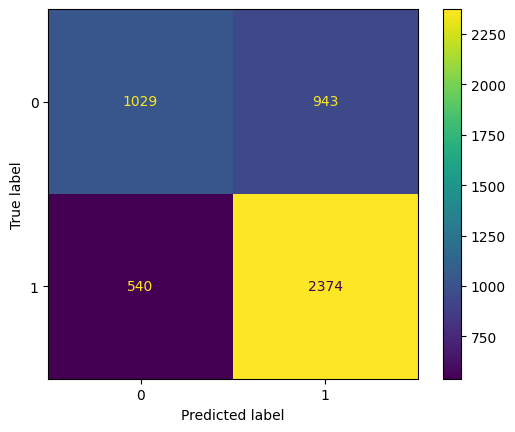

In [24]:
log_reg = LogisticRegression(solver='saga', max_iter = 5000)

model_trials(log_reg, 'Logistic Regression')

### Analysis
This model performed better than the baseline by about 10%, but is struggling with correctly predicting the non-recidivist observations (0 class). This may be a result of the data, or could have to do with the distribution of the data (slight lean towards recidivism = True). 

If we see similar misclassifications in some or most of the subsequent models, it may be necessary to rebalance the data via undersampling or resampling with synthetic data points.

--- 

## Multinomial Naive Bayes

Multinomial Naive Bayes
Training Score: 0.6118
Testing Score: 0.6081 

Accuracy: 0.6081
Specificity: 0.4255
Precision: 0.653
Recall: 0.7316
F1 Score: 0.6901 

Best accuracy rate confusion matrix:


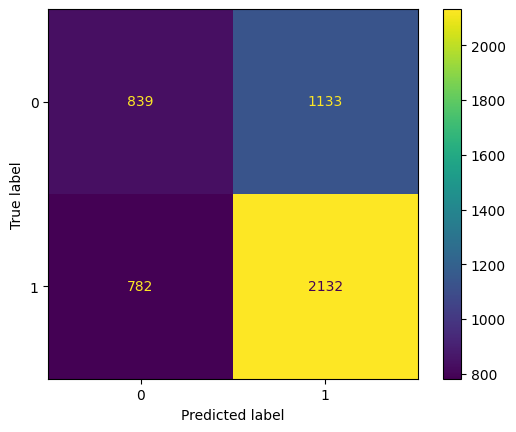

In [25]:
mnb = MultinomialNB()

model_trials(mnb, 'Multinomial Naive Bayes')

### Analysis
This MNB model performed surprisingly poorly and had significantly more false positives and false negatives relative to the Logistic Regression model. 

One possible explanation is that NB classifiers operate on the principle that the presence of one feature does not affect the presence of another. This assumption is not true of this dataset - many features are highly correlated and the presence of 'age_at_release_33-37', for example, would directly result in the absence of a true value in the 'age_at_release_48 or older' column. 

In this case, the model is running on an assumption that is categorically false and would likely run into issues, even in a binary classification model. 

---

## KNN Classifier

KNN
Training Score: 0.7695
Testing Score: 0.6502 

Accuracy: 0.6502
Specificity: 0.5345
Precision: 0.6981
Recall: 0.7286
F1 Score: 0.713 

Best accuracy rate confusion matrix:


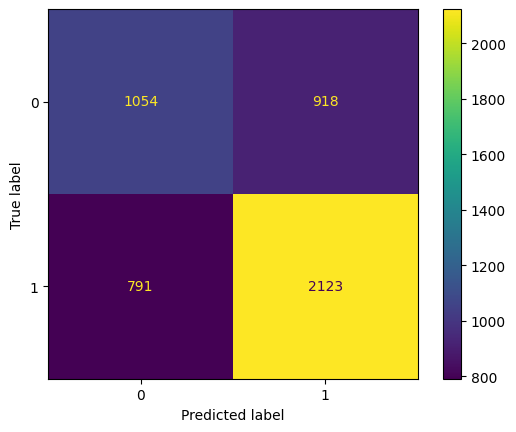

In [26]:
knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

model_trials(knn, 'KNN')

### Analysis
Despite the higher scores, the KNN model saw a handful more false negatives compared to the MNB model above. That being said, both models scored not much higher than the baseline and will likely not be used in the model tuning portion. 

Because KNN performs well with a low number of features, it's probable that the 42 features included in the dummy dataframe are creating too much noise for this model to read through. This, in addition to the fact that KNN uses the mode of the closest observations in a classification model (and our data is not evenly balanced) are two feasible explanations of the low scores seen here.

---

## Decision Tree Classifier

Decision Tree
Training Score: 1.0
Testing Score: 0.623 

Accuracy: 0.623
Specificity: 0.5538
Precision: 0.6893
Recall: 0.6699
F1 Score: 0.6794 

Best accuracy rate confusion matrix:


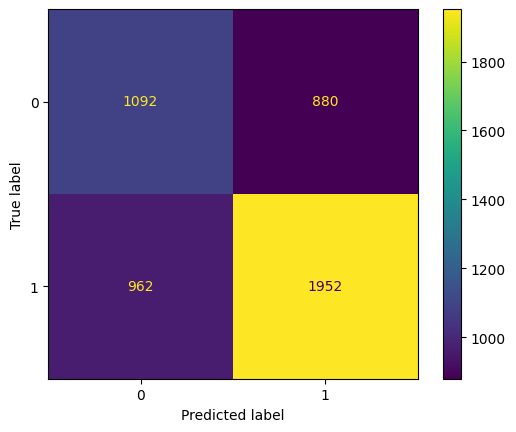

In [27]:
dtree = DecisionTreeClassifier(random_state=42)

model_trials(dtree, 'Decision Tree')

### Analysis
Depending on our evaluation metric, this model did or did not perform well. We're seeing a 0.62 accuracy score, which is not far above the baseline. However, we're also seeing the highest specificity score of the four models tested so far. By definition, this tells us that the Decision Tree model had the lowest number of false positives, and the greatest number of false negatives. 

Additionally, the model is very overfit. While adding max depth or min samples as hyperparameters would likely reduce the variance, we'd still expect a Random Forest or Bagging model to perform better in this context because both are adding randomness to the samples that the Decision Tree model does not.

---

## Random Forest Classifier

Random Forest
Training Score: 1.0
Testing Score: 0.7063 

Accuracy: 0.7063
Specificity: 0.5517
Precision: 0.7277
Recall: 0.8109
F1 Score: 0.7671 

Best accuracy rate confusion matrix:


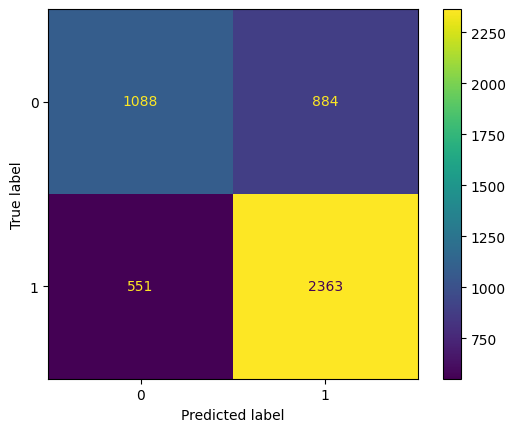

In [28]:
rf = RandomForestClassifier(random_state=42)

model_trials(rf, 'Random Forest')

### Analysis
This model is also very overfit, but significantly decreased the number of false negatives in comparison to the Decision Tree model above. We're seeing the specificity score on par with the prior trials, but the Random Forest model looks to have classified more similarly to the Logistic Regression model than DTree.

The .706 score is our highest accuracy so far, and a strong contender for the upcoming model tuning.

---

## Bagging Classifier

Bagging
Training Score: 0.986
Testing Score: 0.6682 

Accuracy: 0.6682
Specificity: 0.6045
Precision: 0.7266
Recall: 0.7114
F1 Score: 0.7189 

Best accuracy rate confusion matrix:


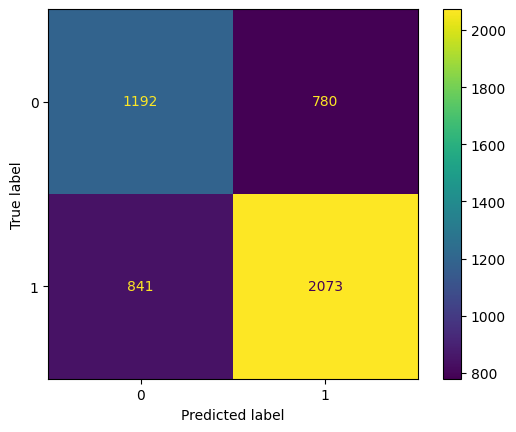

In [29]:
bag = BaggingClassifier(random_state=42)

model_trials(bag, 'Bagging')

### Analysis
Because Bagging is often used when we need to reduce the variance of a Decision Tree model, this model does meet the objective, in that sense.

However, the model is, again, pretty overfit and scoring higher than the baseline by a slim margin. It does well classifying the true negatives but not as well classifying the true positives, relative to the others. 

Overall, we aren't thrilled with the Bagging accuracy score, but it is the third highest so far and a potential option to carry into model tuning.

--- 

## Ada Boost Classifier

AdaBoost
Training Score: 0.7216
Testing Score: 0.7045 

Accuracy: 0.7045
Specificity: 0.5715
Precision: 0.7326
Recall: 0.7944
F1 Score: 0.7623 

Best accuracy rate confusion matrix:


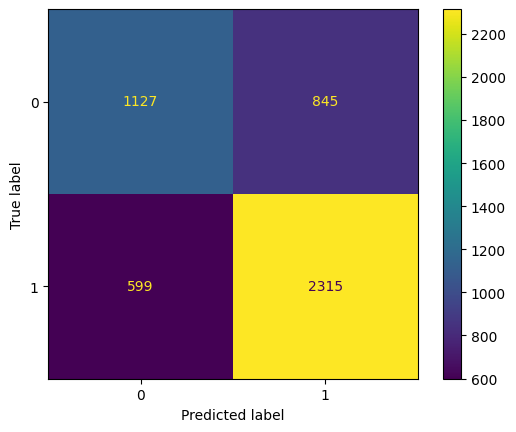

In [30]:
ada = AdaBoostClassifier(random_state=42)

model_trials(ada, 'AdaBoost')

### Analysis
In terms of classification, this AdaBoost model classified very closely to the Random Forest model. Where AdaBoost edges ahead is in the variance of the train and test scores. This model got a similar test score to RF, but shrunk the gap between this and the train score almost entirely. 

This is probably a result of the weighing methods within each of the models - while Random Forest allows an equal vote for each tree, AdaBoost gives some trees/stumps more weight in the final classification than others.

As Logistic Regression was another top-performing trial so far, I think that combining this with a boosting model may lead to higher scores.

---

## Ada Boost Classifier with Logistic Regression

AdaBoost w/ LogReg
Training Score: 0.7216
Testing Score: 0.7045 

Accuracy: 0.7045
Specificity: 0.5715
Precision: 0.7326
Recall: 0.7944
F1 Score: 0.7623 

Best accuracy rate confusion matrix:


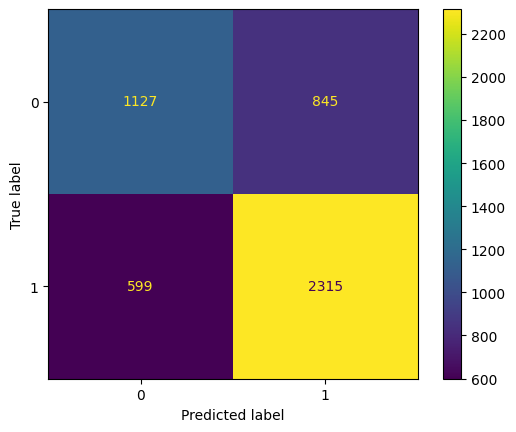

In [31]:
ada_lr = AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42)

model_trials(ada, 'AdaBoost w/ LogReg')

### Analysis
Replacing the Decision Tree base estimator in the AdaBoost model with Logistic Regression did not affect the classifications. This model made all of the same predictions and, therefore, produced all of the same scores as the previous AdaBoost model. 

Though using Logistic Regression in conjunction with AdaBoost did not improve the scores, these models did perform relatively well and may be worth exploring further with hyperparameter tuning.

---

## Gradient Boosting Classifier

Gradient Boosting
Training Score: 0.739
Testing Score: 0.7147 

Accuracy: 0.7147
Specificity: 0.5674
Precision: 0.7356
Recall: 0.8143
F1 Score: 0.773 

Best accuracy rate confusion matrix:


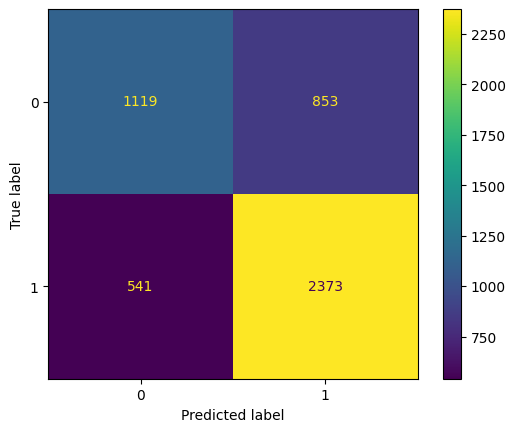

In [32]:
gboost = GradientBoostingClassifier(random_state=42)

model_trials(gboost, 'Gradient Boosting')

### Analysis
The Gradient Boost had the best test score we've seen so far. Though it did not have the most true negatives or true positives, this model outperformed all others on accuracy because it had low numbers of both misclassification types (whereas most of the other models had an inverse relationship between false positives and false negatives).

This model is also not drastically overfit, meaning it is a great option to move forward into model tuning.

---
## Model Evaluation

In [33]:
model_trials_df

,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
0,Logistic Regression,0.709672,0.696480,0.696480,0.521805,0.715707,0.814688,0.761996,1029,943,540,2374
1,Multinomial Naive Bayes,0.611771,0.608064,0.608064,0.425456,0.652986,0.731640,0.690079,839,1133,782,2132
2,KNN,0.769550,0.650225,0.650225,0.534483,0.698126,0.728552,0.713014,1054,918,791,2123
3,Decision Tree,1.000000,0.623005,0.623005,0.553753,0.689266,0.669870,0.679429,1092,880,962,1952
4,Random Forest,1.000000,0.706304,0.706304,0.551724,0.727749,0.810913,0.767083,1088,884,551,2363
5,Bagging,0.986029,0.668236,0.668236,0.604462,0.726604,0.711393,0.718918,1192,780,841,2073
6,AdaBoost,0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315
7,AdaBoost w/ LogReg,0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315
8,Gradient Boosting,0.739048,0.714695,0.714695,0.567444,0.735586,0.814345,0.772964,1119,853,541,2373


- Of the nine models tested, the Gradient Boosting model produced the highest accuracy, precision, and F1 scores.  
- Multinomial Naive Bayes had lowest accuracy and specificity, and appeared to struggle with overpredicting recidivism - this is the only model with greater than 1,000 false positives.
- Gradient Boost had the best overall accuracy, but lost to Bagging and both Ada Boost on specificity.
- Logistic Regression and Gradient Boost had significantly less false negative predictions than most other models, meaning these two were better at not classifying non-recidivism in true recidivism observations.

---
## Model Tuning

Here are the previous models, in order of accuracy. I'll be referring to this list to decide which models to add hyperparameters to, and which ones did not score high enough to run again.

In [34]:
model_trials_df.sort_values(by='accuracy', ascending=False)

,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
8,Gradient Boosting,0.739048,0.714695,0.714695,0.567444,0.735586,0.814345,0.772964,1119,853,541,2373
4,Random Forest,1.000000,0.706304,0.706304,0.551724,0.727749,0.810913,0.767083,1088,884,551,2363
6,AdaBoost,0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315
7,AdaBoost w/ LogReg,0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315
0,Logistic Regression,0.709672,0.696480,0.696480,0.521805,0.715707,0.814688,0.761996,1029,943,540,2374
5,Bagging,0.986029,0.668236,0.668236,0.604462,0.726604,0.711393,0.718918,1192,780,841,2073
2,KNN,0.769550,0.650225,0.650225,0.534483,0.698126,0.728552,0.713014,1054,918,791,2123
3,Decision Tree,1.000000,0.623005,0.623005,0.553753,0.689266,0.669870,0.679429,1092,880,962,1952
1,Multinomial Naive Bayes,0.611771,0.608064,0.608064,0.425456,0.652986,0.731640,0.690079,839,1133,782,2132


---
## Gradient Boosting Classifier

In [31]:
print('Previous scores:')
model_trials_df[model_trials_df['model_used'] == 'Gradient Boosting']

Previous scores:


,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
8,Gradient Boosting,0.739048,0.714695,0.714695,0.567444,0.735586,0.814345,0.772964,1119,853,541,2373


In [32]:
gb = GradientBoostingClassifier(random_state=42)

gb_params  = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [3, 5, 7],
    'learning_rate': [0.7, 0.8, 0.9],
    'max_features': [None, 'sqrt']
}

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Gradient Boosting
Best Params: {'learning_rate': 0.7, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}
Training Score: 0.7415
Testing Score: 0.7081 

Accuracy: 0.7081
Specificity: 0.5786
Precision: 0.7362
Recall: 0.7958
F1 Score: 0.7648 

Best accuracy rate confusion matrix:


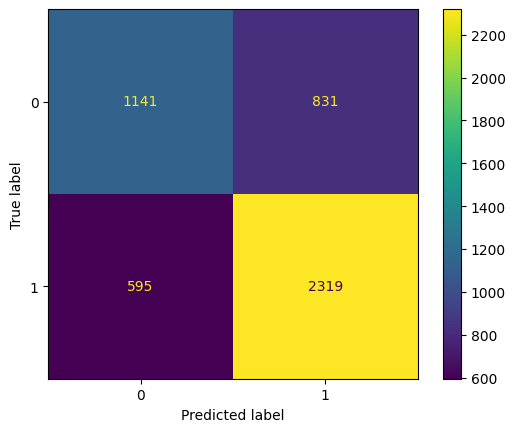

In [33]:
model_trials(gb, gb_params, 'Gradient Boosting')

** Rewrite

### Analysis
- Test score is slightly less than no-param model.
- Decreased false positives, increased false negatives.

---
## Random Forest Classifier

In [34]:
print('Previous scores:')
model_trials_df[model_trials_df['model_used'] == 'Random Forest']

Previous scores:


,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
4,Random Forest,1.0,0.706304,0.706304,0.551724,0.727749,0.810913,0.767083,1088,884,551,2363


In [35]:
rf = RandomForestClassifier(random_state=42)

rf_params  = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [3, 5, 7],
    'max_features': [None, 'sqrt'],
    'bootstrap' : [True, False]
}

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Random Forest
Best Params: {'bootstrap': True, 'max_depth': 7, 'max_features': None, 'n_estimators': 150}
Training Score: 0.742
Testing Score: 0.7022 

Accuracy: 0.7022
Specificity: 0.5497
Precision: 0.7255
Recall: 0.8054
F1 Score: 0.7634 

Best accuracy rate confusion matrix:


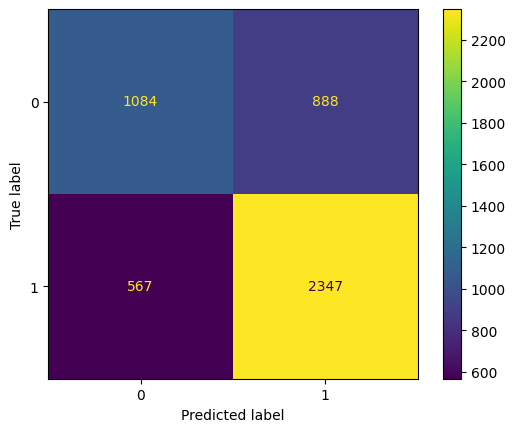

In [36]:
model_trials(rf, rf_params, 'Random Forest')

In [37]:
rf_2 = RandomForestClassifier(random_state=42)

rf_2_params  = {
    'n_estimators': [150, 200, 250], 
    'max_depth': [6, 7, 8],
    'bootstrap' : [True],
    'max_samples': [None, 0.5, 0.8]
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Random Forest v2
Best Params: {'bootstrap': True, 'max_depth': 8, 'max_samples': 0.8, 'n_estimators': 200}
Training Score: 0.7439
Testing Score: 0.7061 

Accuracy: 0.7061
Specificity: 0.4909
Precision: 0.712
Recall: 0.8518
F1 Score: 0.7756 

Best accuracy rate confusion matrix:


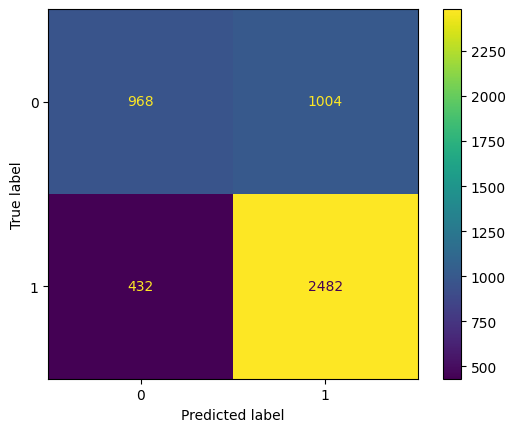

In [38]:
model_trials(rf_2, rf_2_params, 'Random Forest v2')

### Analysis

---
## Ada Boost Classifier

In [39]:
print('Previous scores:')
model_trials_df[model_trials_df['model_used'] == 'AdaBoost']

Previous scores:


,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
6,AdaBoost,0.721648,0.704462,0.704462,0.571501,0.732595,0.794441,0.762265,1127,845,599,2315


In [40]:
ada = AdaBoostClassifier(random_state=42)

ada_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.7, 0.8, 0.9],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
AdaBoost
Best Params: {'learning_rate': 0.7, 'n_estimators': 300}
Training Score: 0.7284
Testing Score: 0.7102 

Accuracy: 0.7102
Specificity: 0.5735
Precision: 0.7355
Recall: 0.8027
F1 Score: 0.7676 

Best accuracy rate confusion matrix:


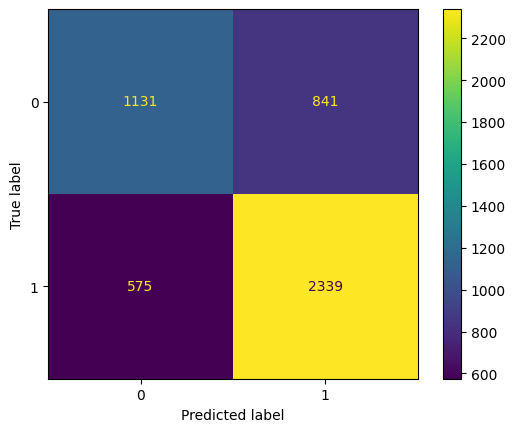

In [41]:
model_trials(ada, ada_params, 'AdaBoost')

In [42]:
ada_2 = AdaBoostClassifier(random_state=42)

ada_params_2 = {
    'n_estimators': [350, 400, 450],
    'learning_rate': [0.6, 0.7, 0.75],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
AdaBoost v2
Best Params: {'learning_rate': 0.6, 'n_estimators': 400}
Training Score: 0.728
Testing Score: 0.7153 

Accuracy: 0.7153
Specificity: 0.5781
Precision: 0.7389
Recall: 0.8082
F1 Score: 0.772 

Best accuracy rate confusion matrix:


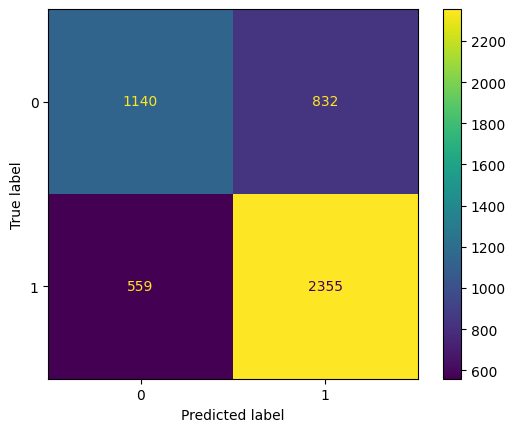

In [43]:
model_trials(ada_2, ada_params_2, 'AdaBoost v2')

### Analysis

Because there is a trade-off between n_estimators and learning_rate, I inversely shifted the range of the two hyperparameters, and this specific model seemed to prefer the lower learning rate and higher amount of estimators.

---
## Logistic Regression

In [44]:
lr = LogisticRegression(random_state=42, max_iter=10_000, solver='saga')

lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None]
}

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Logistic Regression
Best Params: {'C': 10, 'class_weight': None, 'penalty': 'l1'}
Training Score: 0.7098
Testing Score: 0.6971 

Accuracy: 0.6971
Specificity: 0.5233
Precision: 0.7164
Recall: 0.8147
F1 Score: 0.7624 

Best accuracy rate confusion matrix:


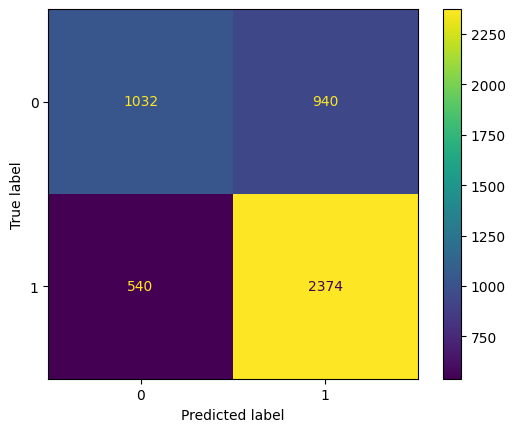

In [45]:
model_trials(lr, lr_params, 'Logistic Regression')

### Analysis


--- 
## Bagging Classifier

In [46]:
bag = BaggingClassifier(random_state=42, n_jobs= -1)

bag_params = {
    'max_samples': [0.5, 0.8, 0.9],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Bagging
Best Params: {'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.5}
Training Score: 0.9559
Testing Score: 0.6746 

Accuracy: 0.6746
Specificity: 0.6379
Precision: 0.7406
Recall: 0.6994
F1 Score: 0.7194 

Best accuracy rate confusion matrix:


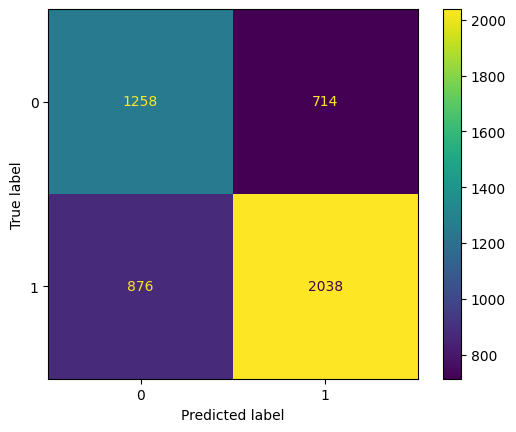

In [47]:
model_trials(bag, bag_params, 'Bagging')

In [48]:
bag_2 = BaggingClassifier(random_state=42, n_jobs= -1)

bag_2_params = {
    'n_estimators': [100, 200, 300],
    'max_samples': [0.5, 0.6],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Bagging v2
Best Params: {'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.6, 'n_estimators': 300}
Training Score: 1.0
Testing Score: 0.7088 

Accuracy: 0.7088
Specificity: 0.5243
Precision: 0.7214
Recall: 0.8336
F1 Score: 0.7734 

Best accuracy rate confusion matrix:


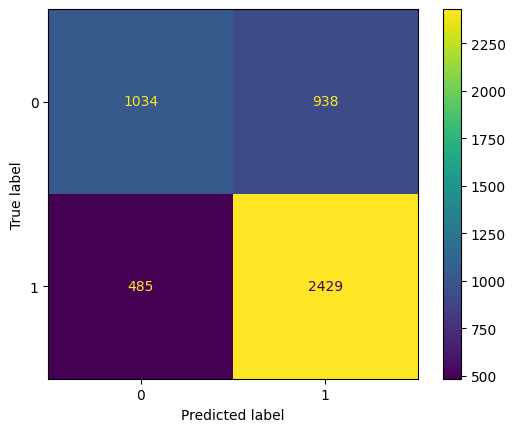

In [49]:
model_trials(bag_2, bag_2_params, 'Bagging v2')

### Analysis


---
## Model Evaluation

In [50]:
# call df here to show all ga scores

,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos,best params
0,Gradient Boosting,0.741505,0.708146,0.708146,0.578600,0.736190,0.795813,0.764842,1141,831,595,2319,"{'learning_rate': 0.7, 'max_depth': 3, 'max_fe..."
1,Random Forest,0.742016,0.702210,0.702210,0.549696,0.725502,0.805422,0.763376,1084,888,567,2347,"{'bootstrap': True, 'max_depth': 7, 'max_featu..."
2,Random Forest v2,0.743859,0.706099,0.706099,0.490872,0.711991,0.851750,0.775625,968,1004,432,2482,"{'bootstrap': True, 'max_depth': 8, 'max_sampl..."
3,AdaBoost,0.728403,0.710192,0.710192,0.573529,0.735535,0.802677,0.767640,1131,841,575,2339,"{'learning_rate': 0.7, 'n_estimators': 300}"
4,AdaBoost v2,0.727994,0.715309,0.715309,0.578093,0.738939,0.808167,0.772005,1140,832,559,2355,"{'learning_rate': 0.6, 'n_estimators': 400}"
5,Logistic Regression,0.709775,0.697094,0.697094,0.523327,0.716355,0.814688,0.762364,1032,940,540,2374,"{'C': 10, 'class_weight': None, 'penalty': 'l1'}"
6,Bagging,0.955937,0.674580,0.674580,0.637931,0.740552,0.699382,0.719379,1258,714,876,2038,"{'bootstrap': False, 'bootstrap_features': Fal..."
7,Bagging v2,1.000000,0.708760,0.708760,0.524341,0.721414,0.833562,0.773444,1034,938,485,2429,"{'bootstrap': False, 'bootstrap_features': Tru..."


In [51]:
# df.describe() to show mean/min/max

,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.00000,8.000000,8.000000
mean,0.793686,0.702799,0.702799,0.557049,0.728310,0.801433,0.762334,1098.50000,873.50000,578.625000,2335.375000
std,0.114882,0.012623,0.012623,0.045295,0.010966,0.045117,0.018025,89.32125,89.32125,131.469646,131.469646
min,0.709775,0.674580,0.674580,0.490872,0.711991,0.699382,0.719379,968.00000,714.00000,432.000000,2038.000000
25%,0.728301,0.700931,0.700931,0.524087,0.720149,0.800961,0.763123,1033.50000,831.75000,526.250000,2334.000000
50%,0.741760,0.707122,0.707122,0.561613,0.730518,0.806795,0.766241,1107.50000,864.50000,563.000000,2351.000000
75%,0.796878,0.709118,0.709118,0.578220,0.736878,0.819406,0.772364,1140.25000,938.50000,580.000000,2387.750000
max,1.000000,0.715309,0.715309,0.637931,0.740552,0.851750,0.775625,1258.00000,1004.00000,876.000000,2482.000000


## Insert final analysis and conclusions here

---
## Feature Importance

In [35]:
X = ga_dummy.drop(columns='recidivism_within_3years')
y = ga_dummy['recidivism_within_3years']

log_reg = LogisticRegression(solver='saga', max_iter = 5000)

log_reg.fit(X, y)

LogisticRegression(max_iter=5000, solver='saga')

In [36]:
fi = log_reg.coef_[0]
fi_zipped = list(zip(X.columns, fi))

feats = pd.DataFrame(columns=['feature', 'coef'])

for i in list(range(len(fi_zipped))):
    feats.loc[i] = [fi_zipped[i][0], np.exp(fi_zipped[i][1])]

feats = feats.sort_values(by='coef', ascending=False)
feats.head(10)

,feature,coef
1,gang_affiliated,2.011781
28,age_at_release_18-22,1.485483
29,age_at_release_23-27,1.348317
0,gender_male,1.345007
12,condition_mh_sa,1.287973
23,drugtests_thc_positive,1.259144
16,violations_instruction,1.252164
15,violations_electronicmonitoring,1.182455
21,residence_changes,1.148552
9,prior_arrest_episodes_ppviolationcharges,1.105202


In [37]:
feats.tail(10)

,feature,coef
19,delinquency_reports,0.893715
31,age_at_release_33-37,0.892416
41,prison_years_more than 3 years,0.841972
37,education_level_less than hs diploma,0.841492
32,age_at_release_38-42,0.825268
35,education_level_at least some college,0.784387
39,prison_years_greater than 2 to 3 years,0.771799
33,age_at_release_43-47,0.742731
34,age_at_release_48 or older,0.564147
27,percent_days_employed,0.294064


### Analysis
- Based on the above, we can see that those who are gang affiliated are twice as likely to recidivate than those who are not.
- Holding all else equal, individuals in the two youngest age groups (18-22 and 23-27) are 35% to 49% more likely to recidivate than those who are not in either age range.
- Men are 34% more likely to recidivate than women.
- Regarding percent of days employed during parole, 21% of observations worked 100% of the days and 31% did not work at all. Those who did not work at all were 71% more likely to recidivate than those who worked all days.
- Individuals who had at least some college experience were 20% less likely to recidivate than those who had no college experience.

In [38]:
feats.to_csv('../data/GA/important_feats.csv')

---
## Conclusion



In [53]:
# Scaling time!
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

NameError: name 'X_train' is not defined

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_sc, y_train)
logreg.score(X_train_sc, y_train), logreg.score(X_test_sc, y_test)

(0.8250031316547664, 0.8275732531930879)

CONCLUSIONS
- Initial accuracy is not terrible!
- Let's try some rebalancing to see if we can improve before we diversify our models.

In [ ]:
# thanks to Devin Fay and General Assembly for this utility function to evaluate rebalancing efforts
def evaluation(X_test, y_test, preds, model, normalize = 'pred'):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
    normalize=normalize)
    
    print(f'balanced_accuracy: {balanced_accuracy_score(y_test, preds)}')
    print(f'recall: {recall_score(y_test, preds, pos_label = 1)}')
    print(f'precision: {precision_score(y_test, preds, pos_label = 1)}')
    print(f'f1 score: {f1_score(y_test, preds, pos_label = 1)}')

balanced_accuracy: 0.8254597532793021
recall: 0.7684210526315789
precision: 0.8086606243705942
f1 score: 0.7880274779195289


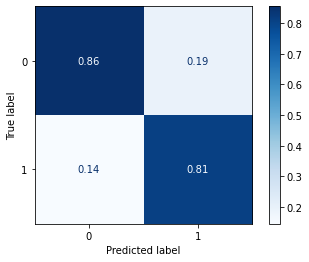

In [ ]:
# let's just balance the class weights and see
logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train_sc, y_train)
preds = logreg.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, logreg)

balanced_accuracy: 0.8282199004003515
recall: 0.7770334928229665
precision: 0.8063555114200596
f1 score: 0.7914230019493177


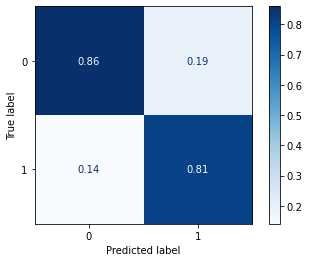

In [ ]:
# let's try random undersampling
rus = RandomUnderSampler()
X_train_sc_rus, y_train_rus = rus.fit_resample(X_train_sc, y_train)
logreg = LogisticRegression()
logreg.fit(X_train_sc_rus, y_train_rus)
preds = logreg.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, logreg)

balanced_accuracy: 0.8150733977801647
recall: 0.8373205741626795
precision: 0.7231404958677686
f1 score: 0.7760532150776053


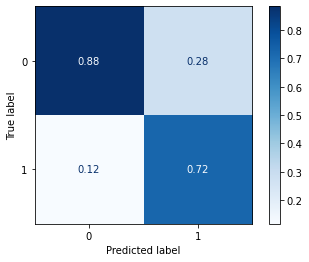

In [ ]:
# let's try NearMiss
nm = NearMiss()
X_train_sc_nm, y_train_nm = nm.fit_resample(X_train_sc, y_train)
logreg = LogisticRegression()
logreg.fit(X_train_sc_nm, y_train_nm)
preds = logreg.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, logreg)

balanced_accuracy: 0.8272043745727956
recall: 0.7712918660287081
precision: 0.8100502512562814
f1 score: 0.7901960784313725


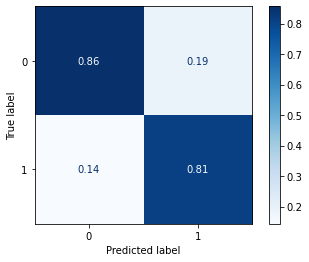

In [ ]:
# let's try RandomOverSampler
ros = RandomOverSampler()
X_train_sc_ros, y_train_ros = ros.fit_resample(X_train_sc, y_train)
logreg = LogisticRegression()
logreg.fit(X_train_sc_ros, y_train_ros)
preds = logreg.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, logreg)

balanced_accuracy: 0.8272043745727956
recall: 0.7712918660287081
precision: 0.8100502512562814
f1 score: 0.7901960784313725


c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "c:\Users\Gabe\anac

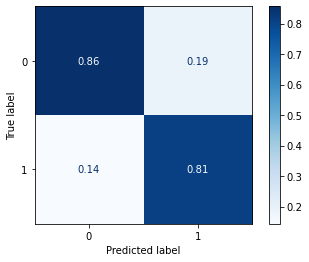

In [ ]:
# how about RandomOverSampler with some tuning?
pipe = ImbalancedPipeline([
    ('ros', RandomOverSampler(random_state = 42)),
    ('logr', LogisticRegression(max_iter = 1_000))
])

gs = GridSearchCV(pipe,
    param_grid = { 'ros__sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1.0]}, scoring = 'balanced_accuracy')

gs.fit(X_train_sc, y_train)
preds = gs.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, gs)

c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "c:\Users\Gabe\anac

balanced_accuracy: 0.8393190769130618
recall: 0.815311004784689
precision: 0.7940354147250699
f1 score: 0.8045325779036826


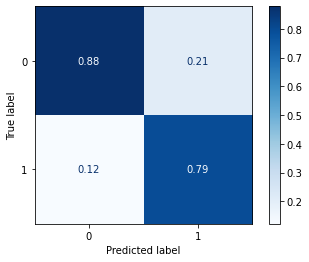

In [ ]:
# We'll give it one more shot with ADASYN
pipe = ImbalancedPipeline([
    ('ada', ADASYN(random_state = 42)),
    ('logr', LogisticRegression(max_iter = 1_000))
])

gs = GridSearchCV(pipe,
    param_grid = { 'ada__sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1.0]}, scoring = 'balanced_accuracy')

gs.fit(X_train_sc, y_train)
preds = gs.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, gs)

CONCLUSIONS
- ADASYN does appear to improve our model slightly, so we will use it to rebalance our target classes

In [ ]:
gs.best_estimator_

Pipeline(steps=[('ada', ADASYN(random_state=42, sampling_strategy=1.0)),
                ('logr', LogisticRegression(max_iter=1000))])

In [ ]:
adasyn = ADASYN(random_state = 42, sampling_strategy = 1.0)
X_train_sc, y_train = adasyn.fit_resample(X_train_sc, y_train)

CONCLUSIONS
- Now that we've dealt with our class imbalance, we can start trying some other models - we'll use GridSearch for most of these.

In [ ]:
# data frame for storing our stats
df_stats = pd.DataFrame(columns = ['model', 'fit_time', 'train_acc', 'test_acc', 'recall', 'precision', 'f1'])

# Thanks to Devin Fay and his Imbalanced Data lesson at GA for the basis of this function
def evaluation(model, model_desc, X_train, y_train, X_test, y_test, normalize = 'pred'):
    '''
    Function to print and acquire some quick model stats.

    Parameters:
        model: the model
        model: description of the model
        X_train, y_train: Training features and target
        X_test, y_test: Testing features and target
        normalize: normalization for ConfusionMatrixDisplay
    Returns:
        Dataframe containing the model, fit time, training accuracy, testing accuracy, recall, precision, and F1
    '''

    start_time = time.time()
    model.fit(X_train, y_train)
    stop_time = time.time()
    fit_time = stop_time - start_time
    preds = model.predict(X_test)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
    normalize=normalize)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    recall = recall_score(y_test, preds, pos_label = 1)
    precision = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)
    
    print(f'fit time: {fit_time}')
    print(f'training set accuracy: {train_acc}')
    print(f'test set accuracy: {test_acc}')
    print(f'recall: {recall}')
    print(f'precision: {precision}')
    print(f'f1 score: {f1}')

    return pd.DataFrame([{'model': model_desc, 'fit_time': fit_time, 'train_acc': train_acc, 'test_acc': test_acc,
        'recall': recall, 'precision': precision, 'f1': f1}])

c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 55, in _check_solver
    raise ValueError(
ValueE

fit time: 0.031536102294921875
training set accuracy: 0.8230423226334083
test set accuracy: 0.8474830954169797
recall: 0.8200956937799043
precision: 0.7972093023255814
f1 score: 0.8084905660377358


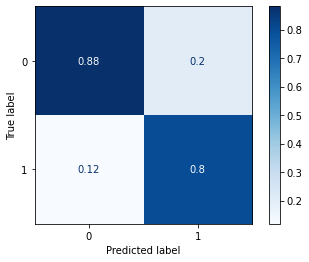

In [ ]:
# LogisticRegression (now with tuning)
logreg = LogisticRegression(random_state = 42)
params = {
    'penalty': ['None', 'l1', 'l2', 'elasticnet'],
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'l1_ratio': [0.1, 0.5, 1.0]
}

gs = GridSearchCV(estimator = logreg, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'Tuned LogisticRegression', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.001169443130493164
training set accuracy: 0.9995910856675526
test set accuracy: 0.7956423741547709
recall: 0.7559808612440191
precision: 0.732159406858202
f1 score: 0.7438794726930319


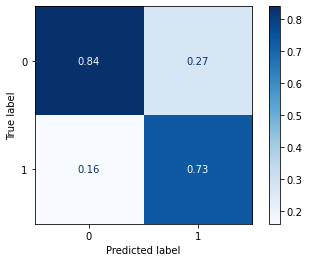

In [ ]:
# KNN
knn = KNeighborsClassifier()
params = {
    'n_neighbors': [3, 5, 8],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}

gs = GridSearchCV(estimator = knn, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'KNearestNeighbors', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.6277241706848145
training set accuracy: 0.9966264567573093
test set accuracy: 0.8666416228399699
recall: 0.8602870813397129
precision: 0.8113718411552346
f1 score: 0.8351137947050628


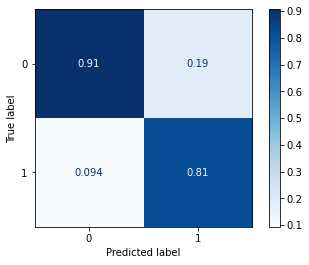

In [ ]:
# Bagging
bag = BaggingClassifier(random_state = 42)
params = {
    'n_estimators': [10, 20]
}

gs = GridSearchCV(estimator = bag, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'BaggingClassifier', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.800511360168457
training set accuracy: 0.9106522183602536
test set accuracy: 0.8677685950413223
recall: 0.938755980861244
precision: 0.7730496453900709
f1 score: 0.8478824546240278


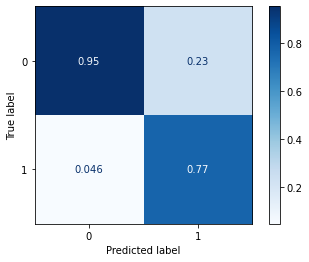

In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state = 42)
params = {
    'n_estimators': [100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator = rf, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'RandomForestClassifier', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.38355588912963867
training set accuracy: 0.8839705581680638
test set accuracy: 0.8613824192336589
recall: 0.9282296650717703
precision: 0.7674050632911392
f1 score: 0.8401905586834126


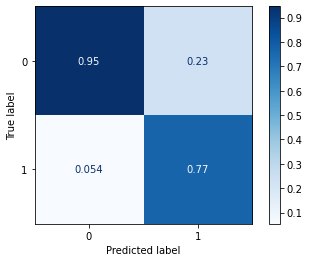

In [ ]:
# AdaBoost
ada = AdaBoostClassifier(random_state = 42)
params = {
    'n_estimators': [50, 100],
    'learning_rate': [1, 5, 10]
}

gs = GridSearchCV(estimator = ada, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'AdaBoostClassifier', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.7518014907836914
training set accuracy: 0.9262931915763648
test set accuracy: 0.877160030052592
recall: 0.9090909090909091
precision: 0.8037225042301185
f1 score: 0.8531656937584194


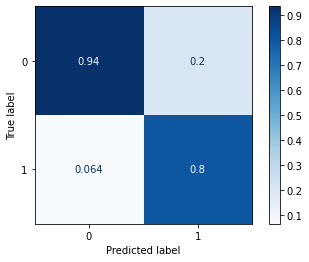

In [ ]:
# GradientBoost
grad = GradientBoostingClassifier(random_state = 42)
params = {
    'n_estimators': [100, 150],
    'subsample': [0.7, 1.0],
    'learning_rate': [0.1, 1, 10],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator = grad, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'GradientBoostingClassifier', X_train_sc, y_train, X_test_sc, y_test)])

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.8642404675483704
test set accuracy: 0.8523666262626648
recall: 0.9416267942583733
precision: 0.7477203647416414
f1 score: 0.8335451080050826


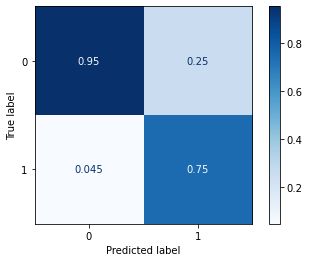

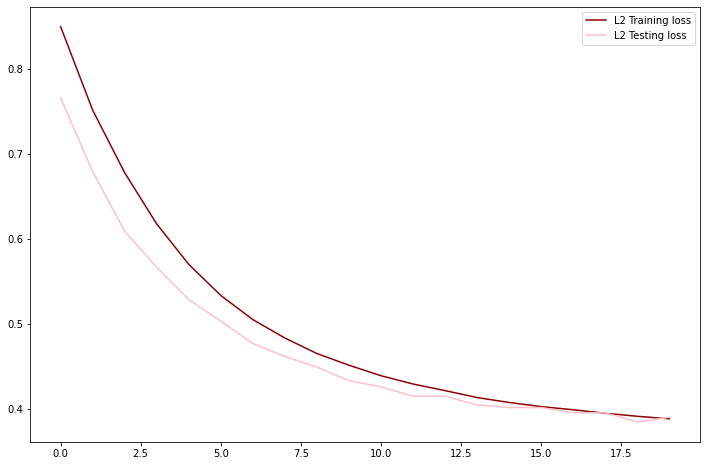

In [ ]:
# L2-regularized FNN
# Model
model = Sequential()
model.add(Dense(units = 32, activation = 'relu', input_shape = (32, ),
    kernel_regularizer = l2(0.005)))
model.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 20, batch_size = 256, verbose = 0)

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.8509507179260254
test set accuracy: 0.8519909977912903
recall: 0.9511961722488038
precision: 0.743455497382199
f1 score: 0.834592779177162


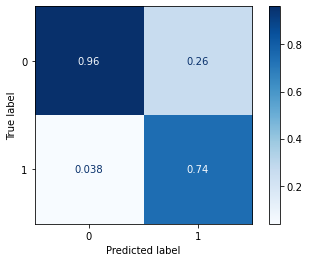

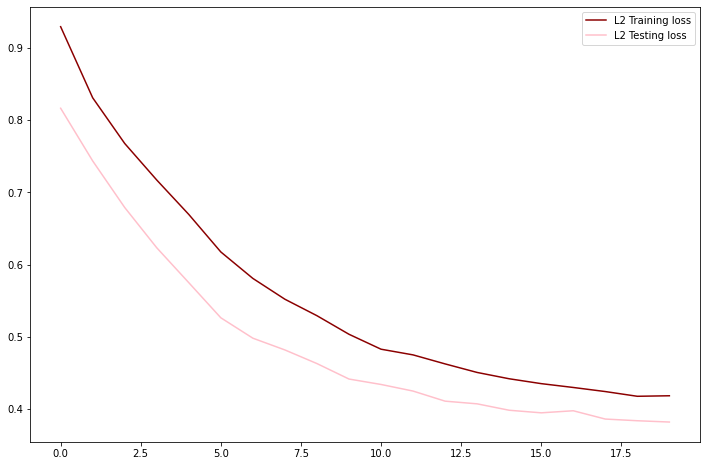

In [ ]:
# Add dropouts
# Model
model = Sequential()
model.add(Dense(units = 32, activation = 'relu', input_shape = (32, ), kernel_regularizer = l2(0.005)))
model.add(Dropout(rate = 0.3))
model.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
model.add(Dropout(rate = 0.3))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 20, batch_size = 256, verbose = 0)

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.8767123222351074
test set accuracy: 0.8621337413787842
recall: 0.9339712918660287
precision: 0.7660910518053375
f1 score: 0.8417421302285467


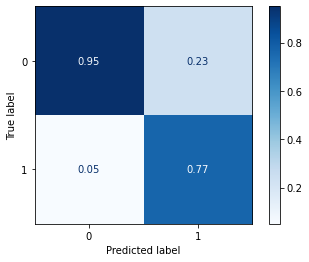

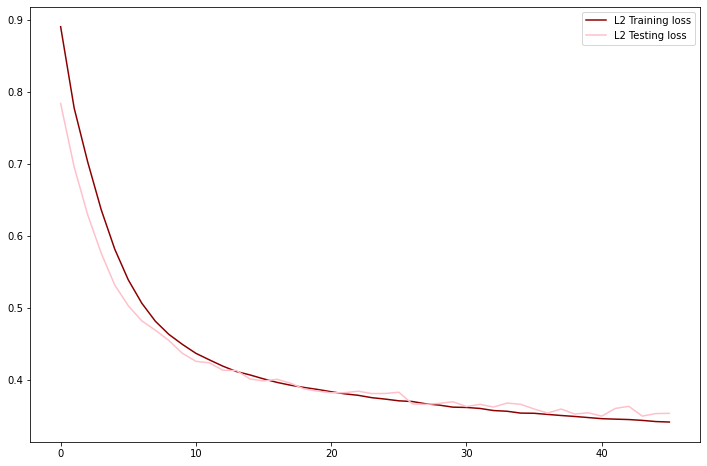

In [ ]:
# L2-regularized FNN with early stopping
es = EarlyStopping(patience = 5)

# Model
model = Sequential()
model.add(Dense(units = 32, activation = 'relu', input_shape = (32, ),
    kernel_regularizer = l2(0.005)))
model.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 100, batch_size = 256, verbose = 0, callbacks = [es])

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.8797791600227356
test set accuracy: 0.8651390075683594
recall: 0.9339712918660287
precision: 0.7709320695102686
f1 score: 0.8446559930765902


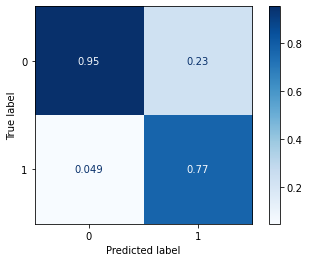

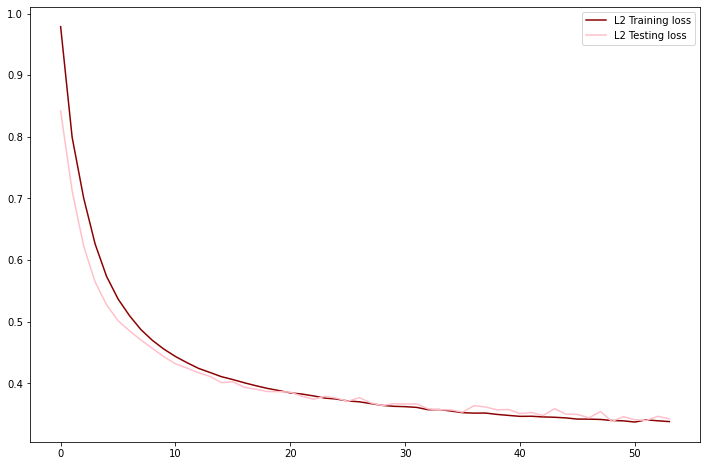

In [ ]:
# PCA on the front end
pca = PCA(random_state = 42)
X_train_sc = pca.fit_transform(X_train_sc)
X_test_sc = pca.transform(X_test_sc)

# L2-regularized FNN with early stopping
es = EarlyStopping(patience = 5)

# Model
model = Sequential()
model.add(Dense(units = 32, activation = 'relu', input_shape = (32, ),
    kernel_regularizer = l2(0.005)))
model.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 100, batch_size = 256, verbose = 0, callbacks = [es])

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

CONCLUSIONS
- It looks like an L2-regularized neural network with early stopping (around 62 epochs or so) gives us the best combination of high accuracy and low variance.
- The recall, precision and F1 for this model are also in keeping with, or better than, the other models.
- This will be our production model for Florida.

**Model 3: Behavioral feature set - Georgia**

**FINAL NOTES**
- The model statistics are exported [here](../data/model_stats.csv).
- The next notebook in the series is [Model Tuning](./04_tuning.ipynb).